In [8]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn
from matplotlib.patches import Rectangle
import seaborn as sns

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import models.Model as Model
import scripts.ModelAdapter as ModelAdapter


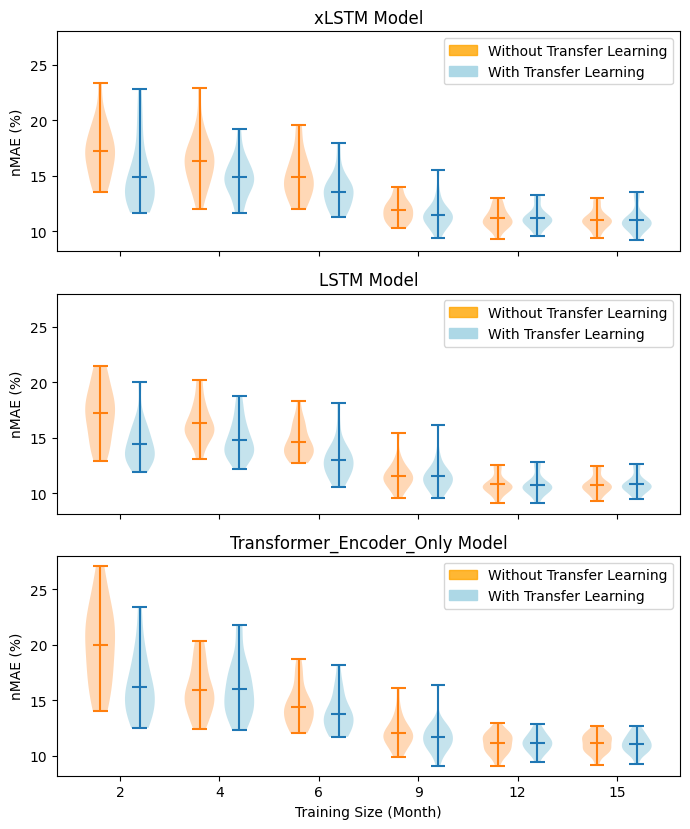

Mean improvment over all models and the first 3 train sizes: 1.692


In [7]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ('xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(7, 2.8*3), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="orange", alpha=0.8, label="Without Transfer Learning"),
    Patch(color="lightblue", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0    
    quantiles = [[0.25, 0.75] for _ in data_with]
    
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=True, showextrema=True, showmedians=False)
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_transfer_learning_over_train_size1.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

# print mean improvement over the first 3 month over all models
max_train_size = 3
all_improvements = np.zeros(shape=(0, max_train_size))
for model in models:
        assert np.array(data_without_transfer[model]).shape == (6, 20), f"Unexptected Shape: {np.array(data_without_transfer[model]).shape}"
        means_without_transfer = np.mean(data_without_transfer[model], axis=1)
        means_with_transfer = np.mean(data_with_transfer[model], axis=1)
        assert means_with_transfer.shape == (6, ), f"Unexptected Shape: {means_with_transfer.shape}"
        diff = (means_without_transfer - means_with_transfer)[:max_train_size]
        diff = diff[np.newaxis, :]
        assert diff.shape == (1, max_train_size,), f"Unexptected Shape: {diff.shape}"
        all_improvements = np.vstack([all_improvements, diff])
assert all_improvements.shape == (len(models), max_train_size), f"Unexptected list length: {all_improvements.shape}"
mean_improvement = np.mean(all_improvements)
print(f"Mean improvment over all models and the first {max_train_size} train sizes: {mean_improvement:.3f}")


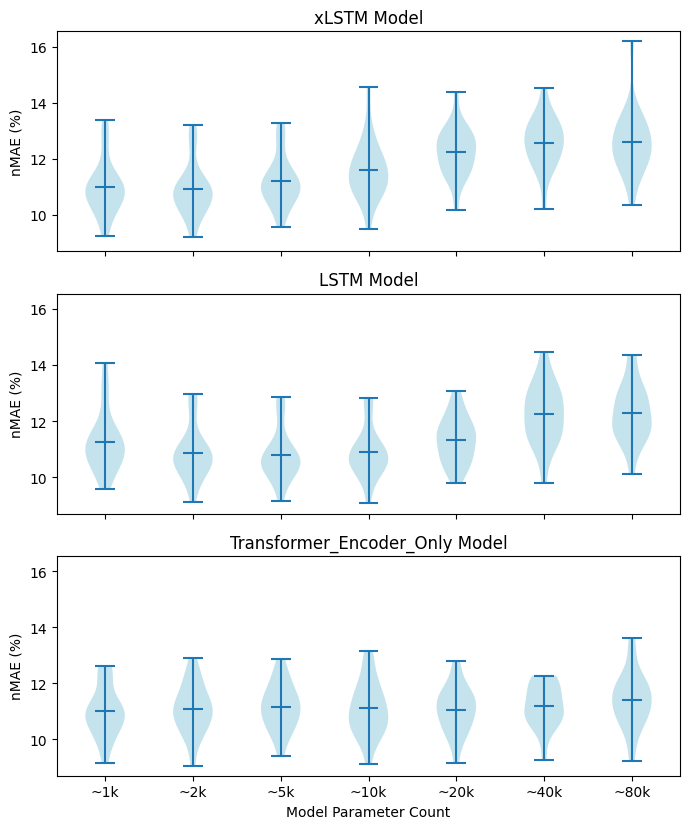

Model xLSTM has a mean range of 1.666 and a std range of 0.269.
Model LSTM has a mean range of 1.488 and a std range of 0.243.
Model Transformer_Encoder_Only has a mean range of 0.410 and a std range of 0.215.


In [ ]:
# Compare the effect of the model sizes
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Constants and Configuration
models = ('xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
training_sizes = ['~1k', '~2k', '~5k', '~10k', '~20k', '~40k', '~80k']

# Prepare data for each model
data_per_model = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(7, 2.8*3), sharex=True, sharey=True)

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data = data_per_model[model]
    
    # Plot the violins
    positions = np.array(range(len(training_sizes))) * 2.0    
    violins = ax.violinplot(data, positions=positions, widths=0.9, 
                                    showmeans=True, showextrema=True, showmedians=False)
        
    for pc in violins['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
#     ax.grid(True, color="0.9")    
    
axes[-1].set_xlabel('Model Parameter Count')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_performance_over_model_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

# plot the deviation in numbers
for model in models:
        data = np.array(data_per_model[model])
        assert data.shape == (7, 20), f"Unexpected Shape: {data.shape}"
        mean_range = max(np.mean(data, axis=1)) - min(np.mean(data, axis=1))
        std_range = max(np.std(data, axis=1)) - min(np.std(data, axis=1))
        print(f"Model {model} has a mean range of {mean_range:.3f} and a std range of {std_range:.3f}.")
        

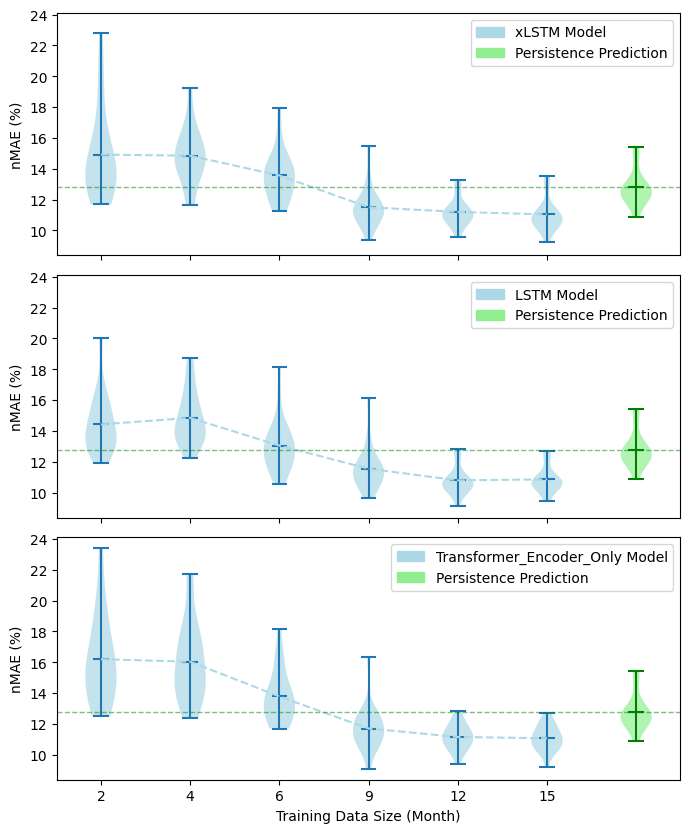

In [9]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
]

# Constants and Configuration
machine_learning_models = ('xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
basic_model = 'PersistencePrediction'
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_ML_models = {model: get_full_data_list(model, configs, result_dict) for model in machine_learning_models}
data_with_basic_model = get_full_data_list(basic_model, configs, result_dict)[0]


# Creating subplots for violin plots
fig, axes = plt.subplots(len(machine_learning_models), 1, figsize=(7, 2.8*3), sharex=True, sharey=True)

# Plot each model's data on a separate subplot
for idx, model in enumerate(machine_learning_models):
    ax = axes[idx]
    
    # Get data for each training size
    data_with_ML_model = data_with_ML_models[model]
        
    # Without Transfer Learning violins
    positions = np.array(range(len(training_sizes))) * 2.0   
    violins_ml_model = ax.violinplot(data_with_ML_model, positions=positions, widths=0.7, 
                                    showmeans=True, showextrema=True, showmedians=False) 
    # With Transfer Learning violins    
    violins_basic_models = ax.violinplot(data_with_basic_model, positions=[positions[0] + 12], widths=0.7, 
                                 showmeans=True, showextrema=True, showmedians=False)
          
    # Connect the means
    data_with_ML_model = np.array(data_with_ML_models[model])
    mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
    ax.plot(positions, mean_data_with_ML_model, label=f'{model} Model',
             linestyle='--', marker='', color='lightblue')  # training_sizes,        

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_ml_model['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_basic_models['bodies']:
        pc.set_facecolor("lightgreen")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)        
    
    # Customize vertical lines
    violins_basic_models['cmeans'].set_color('green')   # Change the color of the mean lines
    violins_basic_models['cmins'].set_color('green')   # Change the color of the minimum lines
    violins_basic_models['cmaxes'].set_color('green')  # Change the color of the maximum lines
    violins_basic_models['cbars'].set_color('green')  # Change the color of the vertical bars (connectors)
    
    # Add horizontal lines for the computed min, max, and mean
    min_basic = min(data_with_basic_model)
    max_basic = max(data_with_basic_model)
    mean_basic = np.mean(data_with_basic_model)    
    # ax.axhline(min_basic, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Min of Basic Model')
    # ax.axhline(max_basic, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Max of Basic Model')
    ax.axhline(mean_basic, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Mean of Basic Model')
            
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    # ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    
    # Add legend to each subplot
    legend_patches = [
        Patch(color="lightblue", label=f"{model} Model"),
        Patch(color="lightgreen", label="Persistence Prediction")
    ]
    ax.legend(handles=legend_patches, loc="upper right")
    


# Add a rectangle that spans across all subplots
# rectangle = Rectangle(
#     (0.45, 0.1),  # Lower-left corner
#     0.05,           # Width
#     0.7,           # Height
#     edgecolor='orange',  # Border color
#     facecolor='none',    # No fill
#     linestyle=':',      # Dashed border
#     linewidth=1,         # Border thickness
#     transform=fig.transFigure,  # Use figure coordinates
#     zorder=1
# )
# fig.add_artist(rectangle)
# fig.text(0.48, 0.92, "Crossing Point", color='grey', ha='center', va='center', fontsize=12, zorder=2)



axes[-1].set_xlabel('Training Data Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_ML_model_vs_persistence_prediction.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.savefig("scripts/outputs/figs/Fig_ML_model_vs_persistence_prediction.svg", format="svg", bbox_inches="tight", pad_inches=0.1)
plt.show()



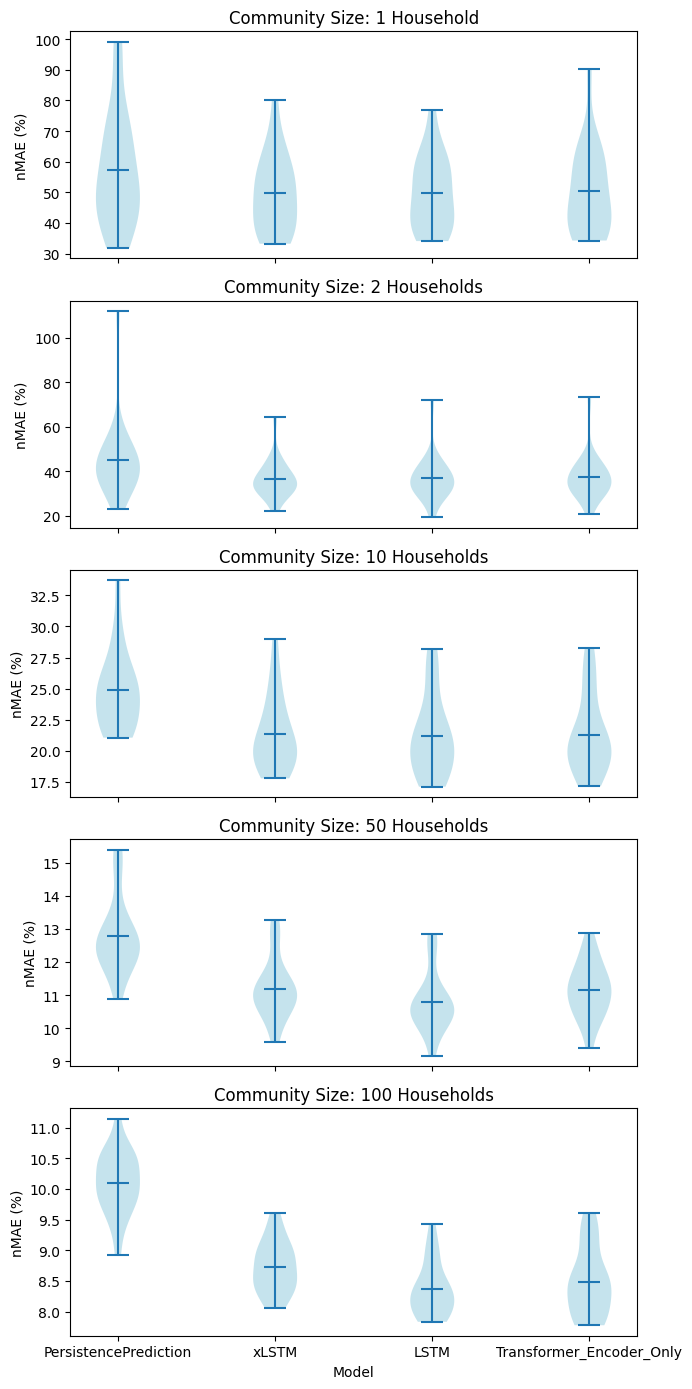

In [11]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(7, 2.8*5), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.28, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    if idx == 0:
        ax.set_title(f"Community Size: {size} Household")
    else:
        ax.set_title(f"Community Size: {size} Households")
    # ax.text(0.5, 0.9, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    # ax.set_ylim(0, None)

    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_community_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


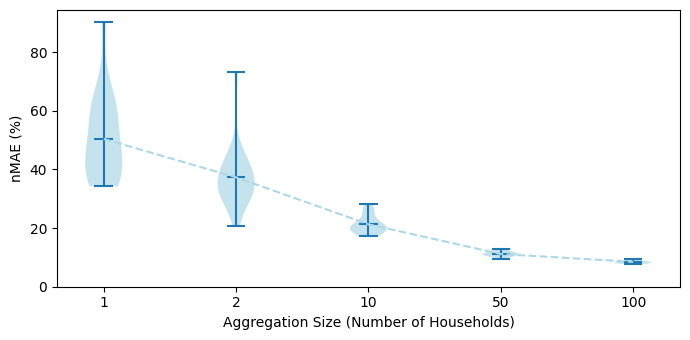

In [14]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}
data = full_data_list['Transformer_Encoder_Only']

# Creating subplots for each household size
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharex=True, sharey=False)
    
# Plot violin plot
positions = np.array(range(len(household_sizes)))
violins = ax.violinplot(data, positions=positions, widths=0.28, 
                        showmeans=True, showextrema=True, showmedians=False)

for pc in violins['bodies']:
    pc.set_facecolor("lightblue")
    # pc.set_edgecolor("black")
    pc.set_alpha(0.7)
    
# Connect the means
data_with_ML_model = np.array(data)
mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
ax.plot(positions, mean_data_with_ML_model, linestyle='--', marker='', color='lightblue')
    
# Labels and title
ax.set_ylabel('nMAE (%)')
# ax.set_title(f"Transformer Model")
# ax.text(0.5, 0.9, f"Transformer Model", transform=ax.transAxes, fontsize=12, ha="center", va="center")
ax.set_xticks(positions)
ax.set_xticklabels(household_sizes)
ax.set_axisbelow(True)
# ax.grid(True, color="0.9")
ax.set_ylim(0, None)
ax.set_xlabel('Aggregation Size (Number of Households)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_community_size2.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


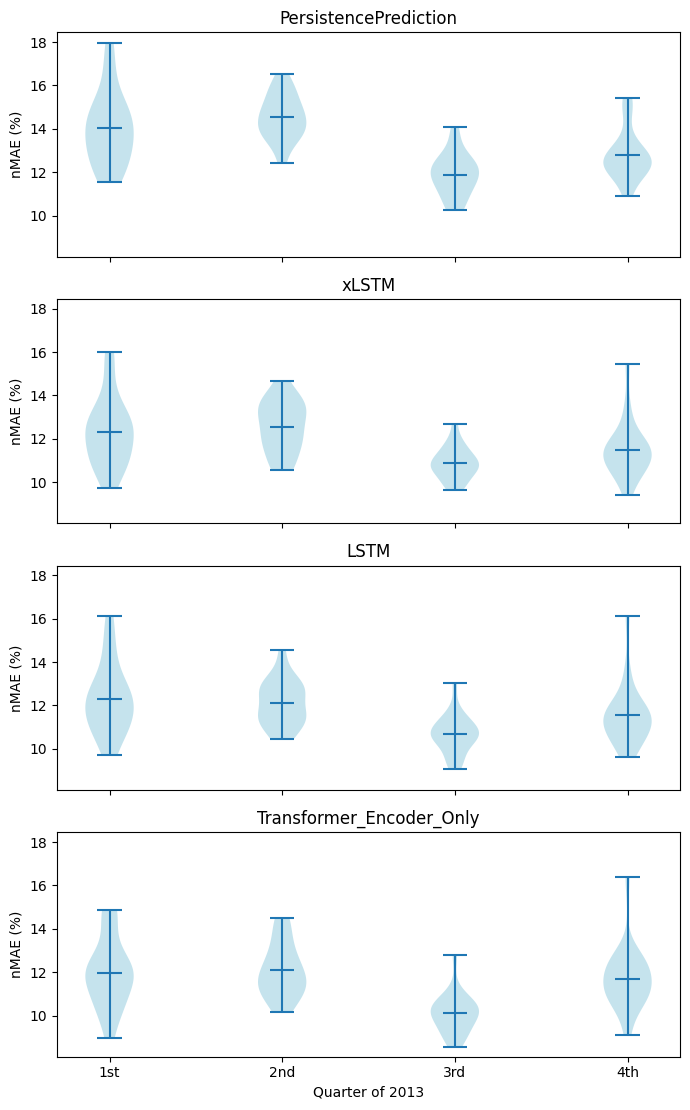

In [16]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

# Define, which configurations to print
# 
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
tested_quartals = ['1st', '2nd', '3rd', '4th']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
data_by_model = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Creating subplots
fig, axes = plt.subplots(len(data_by_model), 1, figsize=(7, 2.8*4), sharex=True, sharey=True)

# Plot each quartal's data on a separate subplot
for idx, (model, data) in enumerate(data_by_model.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.28, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')    
    ax.set_title(f"{model}")
    # ax.text(0.5, 0.9, f"Tested Quartal: {quartal}", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(tested_quartals)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    
    # Set x-axis label for the last plot
    if idx == len(tested_quartals) - 1:
        ax.set_xlabel('Quarter of 2013')

plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_tested_quartals.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [13]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    
   # Vary the tested quartals
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "with Transfer Learning"
config_names = ['1k', '2k', '5k', '10k', '20k', '40k', '80k', 
                'Q1', 'Q2', 'Q3', 'Q4',
                '1', '2', '10', '50', '100',
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [{'name':'Model Size', 'rows':7}, '-', '-', '-', '-', '-', '-', 
                {'name':'Testset<br>(2013)', 'rows':4}, '-', '-', '-',
                {'name':'Community<br>Size', 'rows':5}, '-', '-', '-', '-',
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_with_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)



# Without transfer learning:
#

printed_configs = [
    
    # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "without Transfer Learning"
config_names = [
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
assert len(config_names) == len(config_groups) == len(printed_configs), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(printed_configs)}"
utils.Evaluate_Models.print_latex_table(result_dict, printed_configs, config_groups, config_names)


\hline
\multirow{7}{*}{\rotatebox[origin=c]{90}{\textbf{Model Size}}} 
    & 1k & 11.24 (0.93) & 12.79 (1.13) & 10.86 (1.00) & 12.24 (1.00) & \textbf{10.85} (0.83) \\ 
    & 2k & 11.24 (0.93) & 12.79 (1.13) & 10.90 (1.04) & \textbf{10.79} (0.92) & 10.80 (0.81) \\ 
    & 5k & 11.24 (0.93) & 12.79 (1.13) & 10.94 (0.86) & \textbf{10.70} (0.82) & 10.94 (0.93) \\ 
    & 10k & 11.24 (0.93) & 12.79 (1.13) & 11.44 (0.83) & \textbf{10.75} (0.87) & 10.80 (0.90) \\ 
    & 20k & 11.24 (0.93) & 12.79 (1.13) & 11.86 (0.85) & 11.29 (0.97) & \textbf{10.93} (0.96) \\ 
    & 40k & \textbf{11.24} (0.93) & 12.79 (1.13) & 12.61 (1.01) & 11.88 (1.05) & 11.27 (1.01) \\ 
    & 80k & 11.24 (0.93) & 12.79 (1.13) & 12.65 (0.98) & 12.29 (1.23) & \textbf{11.18} (1.01) \\ 
\hline
\multirow{4}{*}{\rotatebox[origin=c]{90}{\shortstack{\textbf{Testset} \\ \textbf{(2013)}}}} 
    & Q1 & 12.59 (1.09) & 12.79 (1.13) & \textbf{11.38} (1.14) & 11.49 (1.16) & 11.76 (1.54) \\ 
    & Q2 & 11.96 (1.09) & 11.89 (0.97) & 10.75 (0

startdate = 2013-10-01 00:00:00+00:00
nMAE = 4.9% of community 0 on test day 3.
nMAE = 22.8% of community 0 on test day 85.
torch.Size([1, 92])


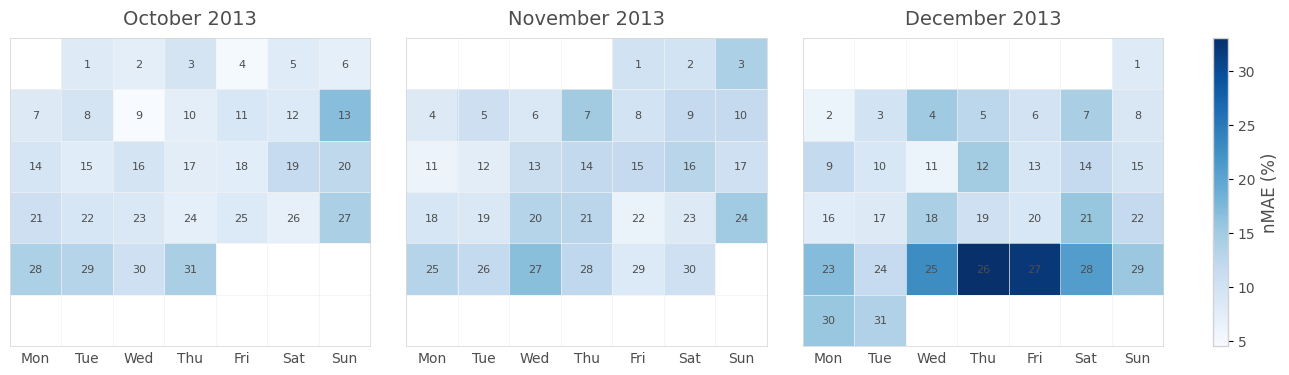

In [20]:
# Create Calendar Plot
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Get specific results
#
path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
myConfig = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer_Encoder_Only'

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(
                        public_holidays_timestamps,
                        trainHistory = myConfig.trainingHistory,
                        testSize = myConfig.testSize,
                        trainFuture = myConfig.trainingFuture,
                        devSize = myConfig.devSize, 
                        )

# Do Predictions
#
nMAE_values = None
communities = [0]
for community_id in communities:
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    num_of_features = X['test'].shape[2]
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, 
                                                   myConfig, num_of_features, modelAdapter)
    Y_pred = modelAdapter.deNormalizeY(my_Model.predict(X['test'])).squeeze()
    Y_real = modelAdapter.deNormalizeY(Y['test']).squeeze()
    loss_fn = nn.L1Loss(reduction='none')
    assert type(loss_fn) == type(my_Model.loss_fn), "Different loss function then in the model chosen!"
    nMAE = (loss_fn(Y_pred, Y_real).mean(dim=1)) / torch.mean(Y_real)
    nMAE = nMAE.unsqueeze(0)
    nMAE *= 100    # Convert to %
    if nMAE_values == None:
        nMAE_values = torch.zeros((0, Y_pred.shape[0]))
    nMAE_values = torch.cat([nMAE_values, nMAE], dim=0)
    
startdate = modelAdapter.getStartDateFromIndex('test', 0)
print(f"startdate = {startdate}")

# Print daily nMAE results of chosen community
#
community_id = communities[0]
test_day_nrs = [3, 85]
for test_day_nr in test_day_nrs:
    print(f"nMAE = {nMAE_values[0, test_day_nr].item():.1f}% " \
          f"of community {community_id} on test day {test_day_nr}.")
    
# Average over the different commnities
#
daily_values = nMAE_values.mean(dim=0)
print(nMAE_values.shape)

# Create plot
#
utils.Evaluate_Models.create_calendar_plot(startdate, daily_values)



In [ ]:
# Plot single results
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [
    Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

]

# Choose an arbitrary configuration to plot
config_names = [
                '1k', '2k', '5k (Baseline)', '10k', '20k', '40k', '80k', 
                # 'Quartal 1', 'Quartal 2', 'Quartal 3', 'Quartal 4 (Baseline)',
                # '1', '2', '10', '50 (Baseline)', '100',
                # '2 mo', '4 mo', '6 mo', '9 mo', '12 mo (Baseline)', '15 mo',
                ]
config_groups = [
                ('Model Size', 7), '-', '-', '-', '-', '-', '-', 
                # ('Testset (2013)', 4), '-', '-', '-',
                # ('Aggregation', 5), '-', '-', '-', '-',
                # ('Training Size', 6), '-', '-', '-', '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_with_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)


\hline
\multirow{7}{*}{\textbf{Model Size}} 
    & 1k & \textbf{15.18} (1.10) \\ 
    & 2k & \textbf{13.57} (0.96) \\ 
    & 5k (Baseline) & \textbf{12.20} (0.92) \\ 
    & 10k & \textbf{11.59} (0.92) \\ 
    & 20k & \textbf{11.29} (0.90) \\ 
    & 40k & \textbf{11.24} (0.93) \\ 
    & 80k & \textbf{11.55} (1.00) \\ 



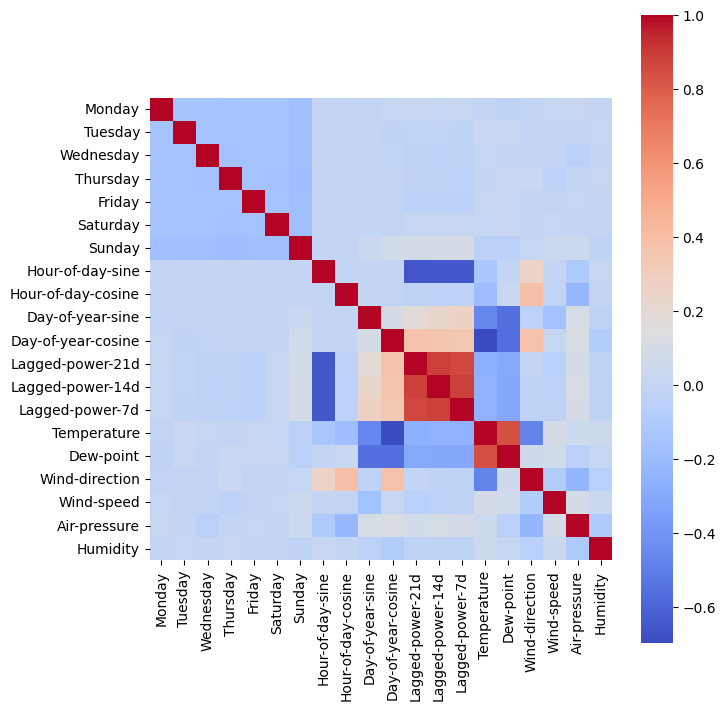

In [74]:
# Evaluate specific model of given power profiles and given configurations
#

importlib.reload(Visualization)
importlib.reload(Model)
importlib.reload(utils)
importlib.reload(ModelAdapter)

# Define a specific configuration
#
community_id = 0  # chose one of many energy communites
myConfig = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            trainHistory = myConfig.trainingHistory,
                                            testSize = myConfig.testSize, 
                                            trainFuture = myConfig.trainingFuture, 
                                            devSize = myConfig.devSize, 
                                            )
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
X['all']

batch, timesteps, features = X['all'].shape

# Flatten across batch and timesteps
x_flat = X['all'].reshape(batch * timesteps, features)
y_flat = Y['all'].reshape(batch * timesteps)

feature_names = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Hour-of-day-sine', 'Hour-of-day-cosine', 'Day-of-year-sine', 'Day-of-year-cosine',
    'Lagged-power-21d', 'Lagged-power-14d', 'Lagged-power-7d',
    'Temperature', 'Dew-point', 'Wind-direction', 'Wind-speed', 'Air-pressure', 'Humidity',
]
assert features == len(feature_names)

df = pd.DataFrame(x_flat, columns=feature_names)
df['Target'] = y_flat

# Compute correlation matrix (excluding the target if needed)
corr_matrix = df.drop(columns=['Target']).corr()
# corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(7.48, 7.48))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_confusion_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()


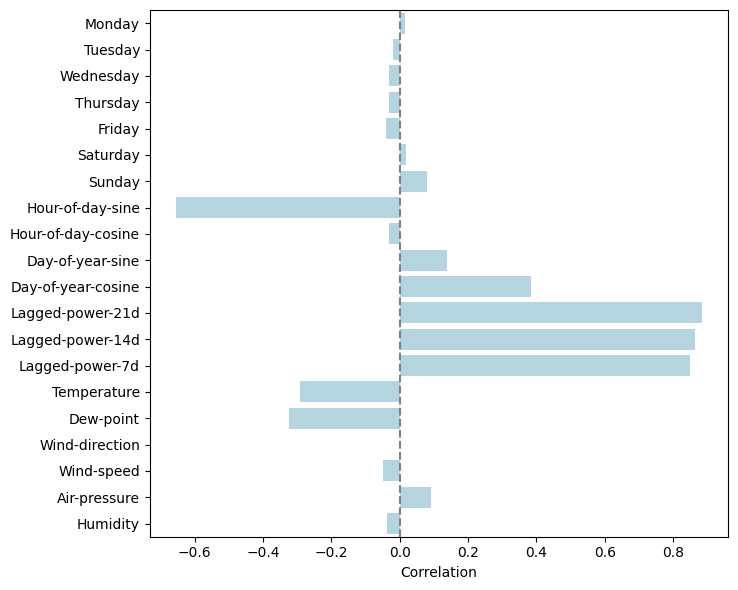

In [75]:
# Compute full correlation matrix
corr = df.corr(numeric_only=True)

# Extract just correlations with the target
target_corr = corr['Target'].drop('Target')  # drop self-correlation

# Convert to DataFrame for nice plotting
target_corr_df = target_corr.to_frame().rename(columns={'Target': 'correlation'})

# Plot as barplot
plt.figure(figsize=(7.48, 6))
sns.barplot(x=target_corr_df.correlation, y=target_corr_df.index, color='lightblue')
# plt.title("Linear Feature Correlation with Target")
plt.xlabel("Correlation")
plt.ylabel("")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_target_correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()
